![example](images/credit-cover.jpeg)

# High-Risk & Low-Risk Credit Card Users

**Authors:** Brent Smart
***

## Overview

The goal of this project is use customer payment history and customer demographic data to help identify high and low risk customers. As new and excisting customers apply for lines of credit, the models will be able to identify 96% of all low and high risk customers. The data contained unverified demographic data on successful and unsucessful applicants, in addition to the payment history of excisting clients. Since only 1% of all records belong to high-risk customers, care had to be taken to account for this imbalance. It is recommended for this bank to 

## Business Problem

Customers at private bank are applying for increases to their line of credit. As the bank decides whether or not to approve those applications, consideration must be made using that user's payment history. The bank needs a way to differentiate between high-risk and low-risk customers. Additionally, excisting customer information can be used to help identify low-risk, new customers. This project focuses on identifying these customers.

## Data Understanding

The two data sets belongs to a private bank that received the applications. The target variable is the customer's current status. This was modified to indicate 0 if the customer either paid on time, didnot use their credit, or missed their payment by a few days. 1 indicates that they missed payments greater than 30 days. In order to keep the number of columns low, each dataset will be analyzed seperately. The other data set will be used in order to supplement any relevant findings. 

In [61]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error,confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline


%matplotlib inline

## Data Preparation

This analysis combines two data sets. One data set detailed a client's payment history. The other data set contained credit card applications. The credit card application contained duplicate applications. It also contained extreme outliers (applicants with 19 children and Annual Salary of more that six million). A column with the calculated Z-score for the number of children and total income was created. The data set with payment history contained the most complete data. 

To help with classification, a column describing unemployment status was added. Additionally, customers where labeled as high-risk if they were delayed by more than a month. 

There is already a column that flags whether or not the appliant owns property or not. To reduce deminsionality, the 'NAME_HOUSING_TYPE' is dropped. Additionally, there is a column flagging unpemployed appliants. There is no need to specify income type and this column was dropped.

In order to reduce dimensionality, education level and marriage status were recategorized.

In [7]:
credit_rec = pd.read_csv("./data/cleaned_data/credit_rec.csv", index_col=0)
credit_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   ID              1048575 non-null  int64
 1   MONTHS_BALANCE  1048575 non-null  int64
 2   STATUS          1048575 non-null  int64
dtypes: int64(3)
memory usage: 32.0 MB


In [8]:
application_hist = pd.read_csv("./data/cleaned_data/application_hist.csv", index_col=0)
application_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28864 entries, 0 to 438552
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           28864 non-null  int64  
 1   CODE_GENDER                  28864 non-null  object 
 2   FLAG_OWN_CAR                 28864 non-null  object 
 3   FLAG_OWN_REALTY              28864 non-null  object 
 4   CNT_CHILDREN                 28864 non-null  int64  
 5   AMT_INCOME_TOTAL             28864 non-null  float64
 6   NAME_FAMILY_STATUS           28864 non-null  object 
 7   DAYS_EMPLOYED                28864 non-null  int64  
 8   CNT_FAM_MEMBERS              28864 non-null  float64
 9   DOB                          28864 non-null  object 
 10  AGE                          28864 non-null  int64  
 11  UNEMPLOYED                   28864 non-null  int64  
 12  EMPLOYMENT_CAT               28864 non-null  object 
 13  HIGHEST_EDUCATI

In [9]:
df = pd.merge(credit_rec,application_hist, how="inner", on="ID")
df.head()

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,DAYS_EMPLOYED,CNT_FAM_MEMBERS,DOB,AGE,UNEMPLOYED,EMPLOYMENT_CAT,HIGHEST_EDUCATION_COMPLETED
0,5008804,0,0,M,Y,Y,0,427500.0,Married,-4542,2.0,1989-05-08 06:09:39.736474,33,0,Other,College
1,5008804,-1,0,M,Y,Y,0,427500.0,Married,-4542,2.0,1989-05-08 06:09:39.736474,33,0,Other,College
2,5008804,-2,0,M,Y,Y,0,427500.0,Married,-4542,2.0,1989-05-08 06:09:39.736474,33,0,Other,College
3,5008804,-3,0,M,Y,Y,0,427500.0,Married,-4542,2.0,1989-05-08 06:09:39.736474,33,0,Other,College
4,5008804,-4,0,M,Y,Y,0,427500.0,Married,-4542,2.0,1989-05-08 06:09:39.736474,33,0,Other,College


In [10]:
df.loc[df['STATUS'] == 1].groupby(['ID']).count().shape

(992, 15)

In [11]:
df.shape
df.groupby(['ID']).count().shape
df['STATUS'].value_counts()

0    177778
1      2535
Name: STATUS, dtype: int64

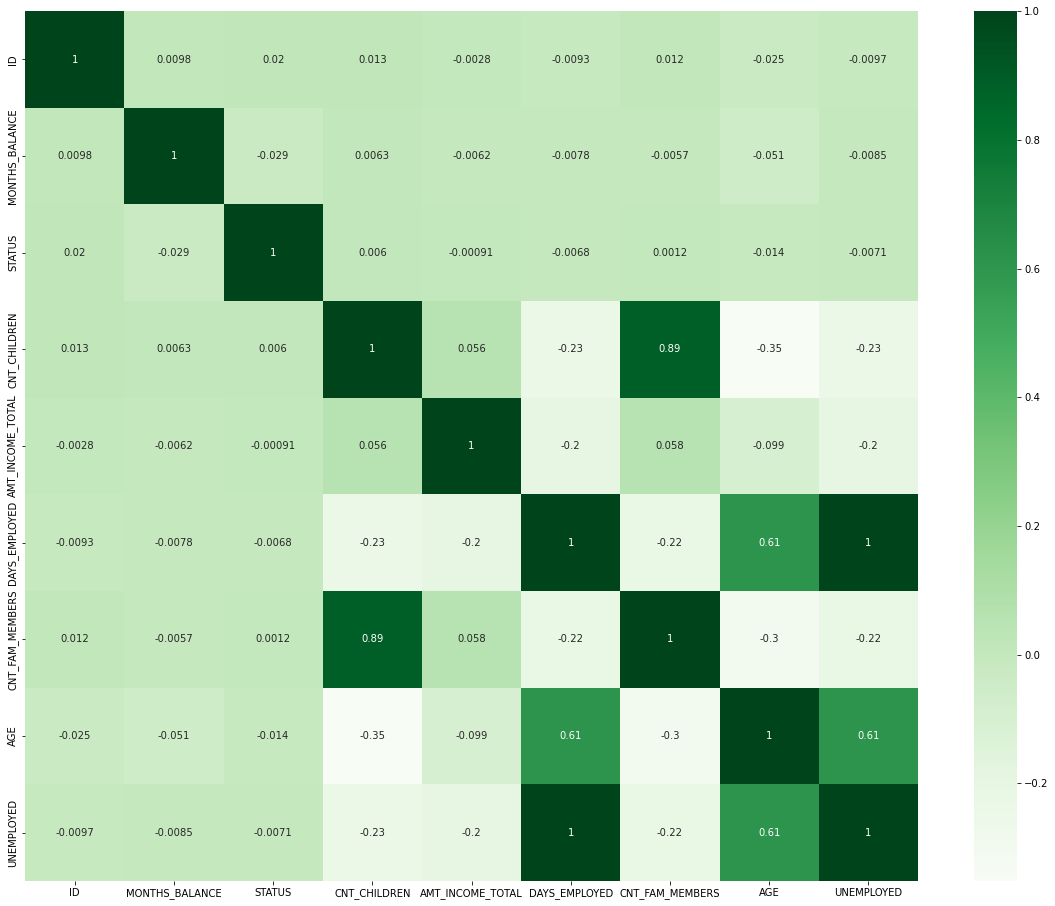

In [12]:
fig1, ax1 = plt.subplots(figsize=(20,16))
sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.show()

In [13]:
# Dealing with multicolinarity and unnessary cols

df.drop(['DAYS_EMPLOYED','CNT_CHILDREN', 'MONTHS_BALANCE','DOB'], axis=1, inplace=True)

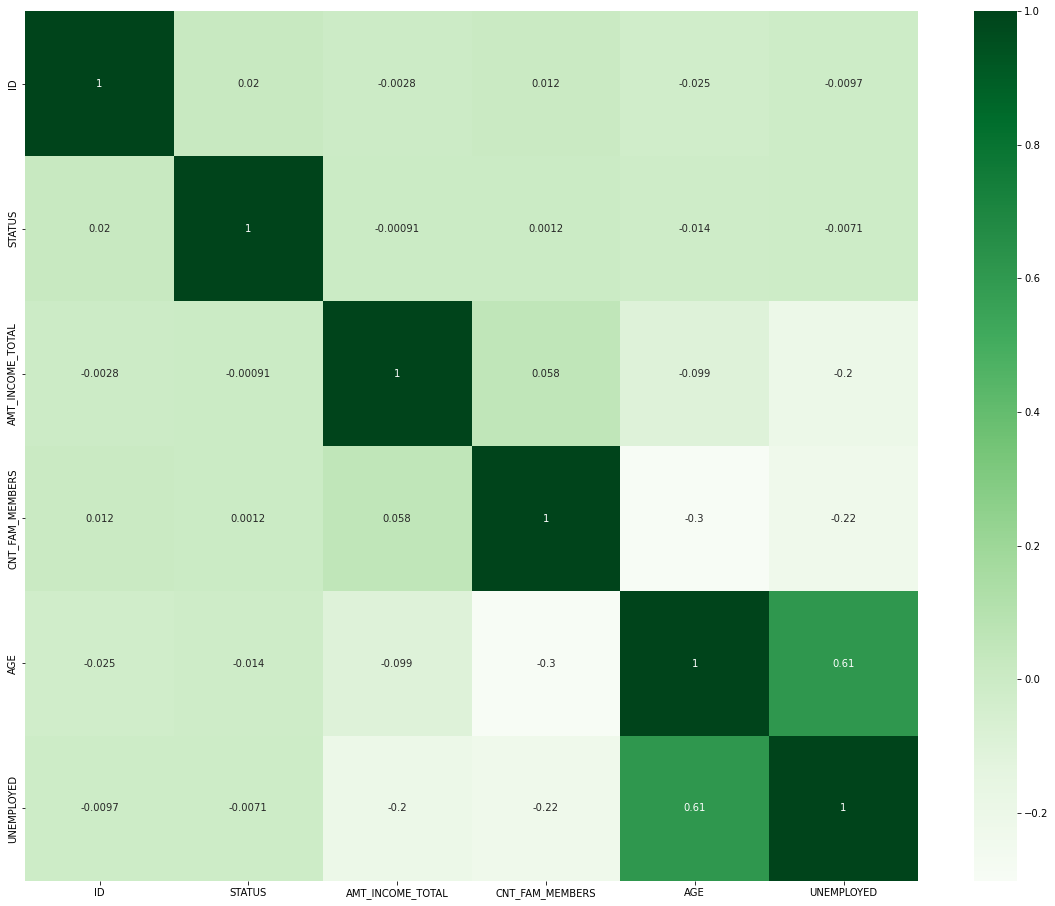

In [14]:
fig1, ax1 = plt.subplots(figsize=(20,16))
sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.show()

In [15]:
# sns.pairplot(df)
# plt.show()

In [33]:
#Encoding categorical features
df_copy = df
df = pd.get_dummies(df, columns=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_FAMILY_STATUS','EMPLOYMENT_CAT','HIGHEST_EDUCATION_COMPLETED'],drop_first=True)

KeyError: "None of [Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_FAMILY_STATUS',\n       'EMPLOYMENT_CAT', 'HIGHEST_EDUCATION_COMPLETED'],\n      dtype='object')] are in the [columns]"

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [34]:
y = df['STATUS']
X = df.drop(['STATUS'],axis=1)

##### Model - Ignoring Data Imbalance

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(135234, 19)

f1 score: 0.0
Accuracy: 0.9866456664965949
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     44477
           1       0.00      0.00      0.00       602

    accuracy                           0.99     45079
   macro avg       0.49      0.50      0.50     45079
weighted avg       0.97      0.99      0.98     45079



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


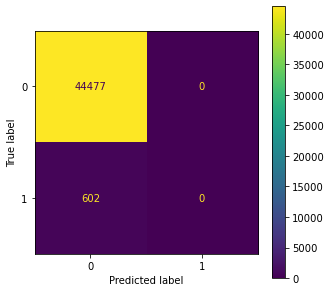

In [36]:
# Fit model to training data
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(X_train, y_train)

#Predicting using test data
y_predict = clf.predict(X_test)

print("f1 score:", f1_score(y_test, y_predict))
print("Accuracy:", accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=clf.classes_)
disp.plot()

plt.show()

Above, the model does not account for the imbalanced data. According to this model, all customers are predicted as low-risk. This is inaccurate. Using this model will expose the company to too much risk.

##### Accounting for Data Imbalance

In [37]:
# Accounting for data imbalance in train_test split and choosing best classifier.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_train.shape

(135234, 19)

Results for:  LogisticRegression(class_weight='balanced', random_state=42) 

f1 score: 0.027444876783398183
Accuracy: 0.16830453204374543
              precision    recall  f1-score   support

           0       0.99      0.16      0.27     44445
           1       0.01      0.83      0.03       634

    accuracy                           0.17     45079
   macro avg       0.50      0.50      0.15     45079
weighted avg       0.97      0.17      0.27     45079



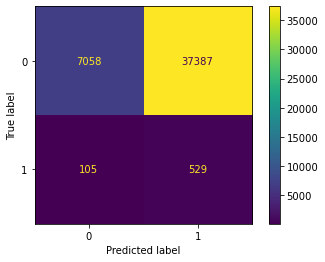

Results for:  DecisionTreeClassifier(class_weight='balanced', random_state=42) 

f1 score: 0.15587936292782106
Accuracy: 0.8894829077841123
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     44445
           1       0.09      0.73      0.16       634

    accuracy                           0.89     45079
   macro avg       0.54      0.81      0.55     45079
weighted avg       0.98      0.89      0.93     45079



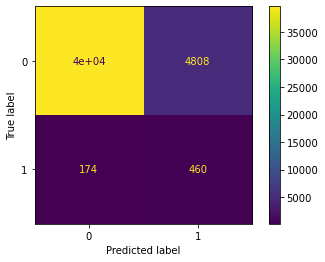

Results for:  RandomForestClassifier(class_weight='balanced', random_state=42) 

f1 score: 0.17866833646420371
Accuracy: 0.9127088001064797
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     44445
           1       0.10      0.68      0.18       634

    accuracy                           0.91     45079
   macro avg       0.55      0.80      0.57     45079
weighted avg       0.98      0.91      0.94     45079



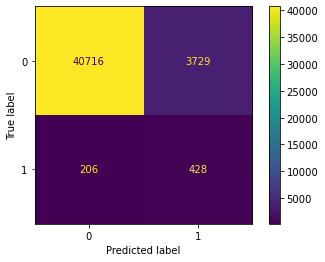

In [17]:
# Fit model to training data (balanced)
lg = LogisticRegression(random_state=42, class_weight='balanced')

dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

algos = [lg, dt, rf]


for algo in algos:
    #Fit and make predictions.
    y_predict = algo.fit(X_train, y_train).predict(X_test)
    
    #Evaluate on test data
    print("Results for: ", algo, '\n')
    print("f1 score:", f1_score(y_test, y_predict))
    print("Accuracy:", accuracy_score(y_test, y_predict))
    print(classification_report(y_test, y_predict), end='\n')

    cm = confusion_matrix(y_test, y_predict, labels=algo.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=algo.classes_)
    disp.plot()

    plt.show()

These models are less accurate, better able to identify high-risk clients than the previous model. Since the focus is to identify high-risk customers, misidentifying a customer as low-risk, when they are infact high-risk (false negatives) would be problematic for the company. The f-score, is therefore a better measure. The f-score for the balanced Decision Tree Classifiers was highest and will be investigated further.   

In [44]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

#find best weights
weights = np.linspace(0.0,0.99,200)
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

rf = GridSearchCV(estimator= dt, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [45]:
# rf = RandomForestClassifier(random_state=42)

# #find best weights
# weights = np.linspace(0.0,0.99,200)
# param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

# rf = GridSearchCV(estimator= rf, 
#                           param_grid= param_grid,
#                           cv=StratifiedKFold(), 
#                           n_jobs=-1, 
#                           scoring='f1', 
#                           verbose=2).fit(X_train, y_train)

In [ ]:
# print("Results for: ", rf.best_estimator_, '\n')
# print("f1 score:", f1_score(y_test, y_predict))
# print("Accuracy:", accuracy_score(y_test, y_predict))
# print(classification_report(y_test, y_predict), end='\n')

# cm = confusion_matrix(y_test, y_predict, labels=rf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                           display_labels=rf.best_estimator_.classes_)
# disp.plot()

# plt.show()
# rf.best_params_
# rf.best_score_

In [18]:
# Accounting for unbalanced data using SMOTENC.

In [19]:
# df_SMOTE = df_copy
# df_SMOTE.info()

# cat = [2,3,4,6,10,11]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180313 entries, 0 to 180312
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           180313 non-null  int64  
 1   STATUS                       180313 non-null  int64  
 2   CODE_GENDER                  180313 non-null  object 
 3   FLAG_OWN_CAR                 180313 non-null  object 
 4   FLAG_OWN_REALTY              180313 non-null  object 
 5   AMT_INCOME_TOTAL             180313 non-null  float64
 6   NAME_FAMILY_STATUS           180313 non-null  object 
 7   CNT_FAM_MEMBERS              180313 non-null  float64
 8   AGE                          180313 non-null  int64  
 9   UNEMPLOYED                   180313 non-null  int64  
 10  EMPLOYMENT_CAT               180313 non-null  object 
 11  HIGHEST_EDUCATION_COMPLETED  180313 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 17.9+ MB


In [25]:
# y_SMOTE = df_SMOTE['STATUS']
# X_SMOTE = df_SMOTE.drop(['STATUS'],axis=1)

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.2, stratify=y, random_state=42)

In [39]:
# X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180313 entries, 0 to 180312
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   ID                                       180313 non-null  int64  
 1   AMT_INCOME_TOTAL                         180313 non-null  float64
 2   CNT_FAM_MEMBERS                          180313 non-null  float64
 3   AGE                                      180313 non-null  int64  
 4   UNEMPLOYED                               180313 non-null  int64  
 5   CODE_GENDER_F                            180313 non-null  uint8  
 6   CODE_GENDER_M                            180313 non-null  uint8  
 7   FLAG_OWN_CAR_N                           180313 non-null  uint8  
 8   FLAG_OWN_CAR_Y                           180313 non-null  uint8  
 9   FLAG_OWN_REALTY_N                        180313 non-null  uint8  
 10  FLAG_OWN_REALTY_Y               

In [41]:
# #Create an oversampled training data
# smotenc = SMOTENC([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], random_state = 42)
# X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train)


In [42]:
# y_oversample.mean()

0.5

Results for:  LogisticRegression(random_state=42) 

f1 score: 0.026165756466422618
Accuracy: 0.28006388784134517
              precision    recall  f1-score   support

           0       0.98      0.27      0.43     44445
           1       0.01      0.69      0.03       634

    accuracy                           0.28     45079
   macro avg       0.50      0.48      0.23     45079
weighted avg       0.97      0.28      0.42     45079



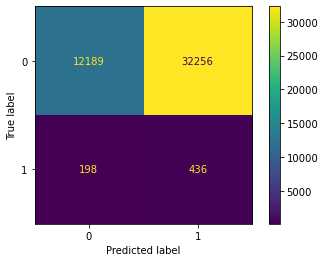

Results for:  DecisionTreeClassifier(random_state=42) 

f1 score: 0.2389937106918239
Accuracy: 0.9570531733179529
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     44445
           1       0.16      0.48      0.24       634

    accuracy                           0.96     45079
   macro avg       0.58      0.72      0.61     45079
weighted avg       0.98      0.96      0.97     45079



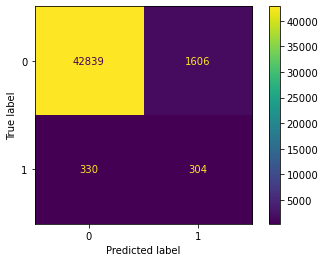

Results for:  RandomForestClassifier(random_state=42) 

f1 score: 0.24059561128526646
Accuracy: 0.9570088067614632
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     44445
           1       0.16      0.48      0.24       634

    accuracy                           0.96     45079
   macro avg       0.58      0.72      0.61     45079
weighted avg       0.98      0.96      0.97     45079



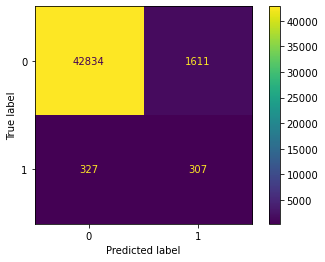

In [43]:
# # Fit model to training data (oversameple and stratified)
# lg = LogisticRegression(random_state=42)

# dt = DecisionTreeClassifier(random_state=42)

# rf = RandomForestClassifier(random_state=42)

# algos = [lg, dt, rf]


# for algo in algos:
#     #Fit and make predictions.
#     y_predict = algo.fit(X_oversample, y_oversample).predict(X_test)
    
#     #Evaluate on test data
#     print("Results for: ", algo, '\n')
#     print("f1 score:", f1_score(y_test, y_predict))
#     print("Accuracy:", accuracy_score(y_test, y_predict))
#     print(classification_report(y_test, y_predict), end='\n')

#     cm = confusion_matrix(y_test, y_predict, labels=algo.classes_)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=algo.classes_)
#     disp.plot()

#     plt.show()

Using SMOTE did increase the F-Score for both Decision Tree and Random Forest. The Random Forest oversampled model was able to identify almost all True Positives (records of high-risk clients) and had the least false-negatives of the oversampled data.

In [44]:
imba_pipeline = make_pipeline(SMOTENC([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=42))
cross_val_score(imba_pipeline, X_train, y_train, scoring='f1', cv=StratifiedKFold())

array([0.26647145, 0.25261584, 0.25      , 0.25275533, 0.24608501])

In [ ]:
imba_pipeline

In [ ]:
params = {'n_estimators': [50, 100, 200],
          'max_depth': [4, 6, 10, 12]}
    
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, 
                         param_grid=new_params, 
                         cv=StratifiedKFold(), 
                         scoring='f1',
                         return_train_score=True)
grid_imba.fit(X_train, y_train)

In [ ]:
grid_imba.best_params_

In [ ]:
grid_imba.best_score_

In [ ]:
# Accounting for data imbalance using XGBoost

In [21]:
# data_dmatrix = xgb.DMatrix(data=X, label=y)

In [54]:
xgb = xgb.XGBClassifier()

In [55]:
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_test)

[16:34:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Results for:  XGBRegressor(aplha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None) 

f1 score: 0.12661870503597122
Accuracy: 0.9865347501053706
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     44445
           1       0.72      0.07      0.13       634

    accuracy                           0.99     45079
   macro avg       0.85      0.53     

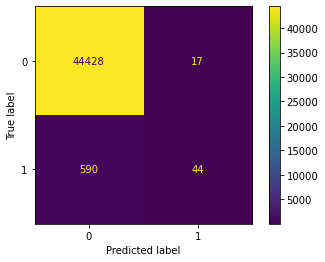

In [56]:
#Evaluate on test data
print("Results for: ", xg_reg, '\n')
print("f1 score:", f1_score(y_test, y_predict))
print("Accuracy:", accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict), end='\n')

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [57]:
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print("RMSE: %f" % (rmse))

RMSE: 0.116040


In [58]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}



In [63]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

grid = GridSearchCV(xgb, param_grid, n_jobs=-1, scoring="roc_auc")

_ = grid.fit(X_train, y_train)

TypeError: estimator should be an estimator implementing 'fit' method, <module 'xgboost' from '/opt/anaconda3/lib/python3.8/site-packages/xgboost/__init__.py'> was passed

In [30]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.452888,0.000017,0.452941,0.000023
1,0.410841,0.000048,0.410876,0.000024
2,0.373370,0.000071,0.373319,0.000050
3,0.339902,0.000078,0.339897,0.000107
4,0.310163,0.000128,0.310184,0.000117


In [40]:
print((cv_results["test-rmse-mean"]).tail(1))


49    0.116872
Name: test-rmse-mean, dtype: float64


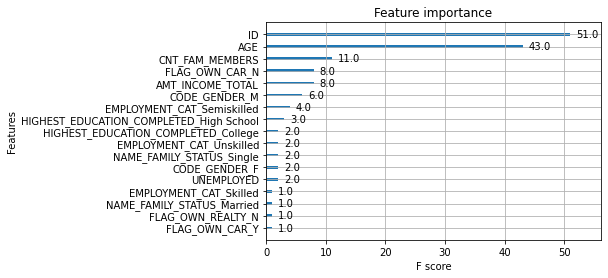

In [32]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

Was suprised that ID was the one being used the most of all the features. Will drop that column and compare the results.

In [ ]:
#try playing around with the 

## Evaluation

The model underwent multiple interactions, each time investigating how well the model was able to predict a user's classification. At the end, the final model showed an overall improvement but was ultimately unable to accurately identify all high-risk clients.
***

## Conclusions
The scope of this investigation involved all current clients. It would be helpful to track more financial data on clients in order to improve the model. When clients opened accounts and when they utlized credit.
***